# Analysis of NASA Server Logs
**Rakesh Karki**

## Introduction:
In this project, we will be conducting various data analysis with a file containing one month of server log data collected from NASA.gov in August 1995.  
Each line in this file contains 6 pieces of information, separated by spaces. These pieces of information are, in order:
1. The IP address or DNS hostname of the server making the request.
2. The date and time of the request.
3. The request type. This has four possible values: GET, POST, and HEAD.
4. The location of the resource being requested.
5. The HTTP status code the server sent back to the client.
6. The number of bytes transferred to the client. This is set as a hyphen character '-' in some records.

## Part A: Set up Environment
We will start by importing the required packages for the analysis.

In [0]:
import pyspark.sql
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

## Part B: Load and Process Data
Now, we will load data from local file and begin the data analysis.

Load the data from local file and count the number of elements to understand the size of data.

In [0]:
nasa_raw = sc.textFile('/FileStore/tables/NASA_server_logs_Aug_1995.txt')
nasa_raw.count()

Out[2]: 1569888

Now, we will preview the first 10 rows of the data.

In [0]:
for rows in nasa_raw.take(10):
  print(rows)

in24.inetnebr.com [01/Aug/1995:00:00:01] "GET /shuttle/missions/sts-68/news/sts-68-mcc-05.txt" 200 1839
uplherc.upl.com [01/Aug/1995:00:00:07] "GET /" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/ksclogo-medium.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/MOSAIC-logosmall.gif" 304 0
uplherc.upl.com [01/Aug/1995:00:00:08] "GET /images/USA-logosmall.gif" 304 0
ix-esc-ca2-07.ix.netcom.com [01/Aug/1995:00:00:09] "GET /images/launch-logo.gif" 200 1713
uplherc.upl.com [01/Aug/1995:00:00:10] "GET /images/WORLD-logosmall.gif" 304 0
slppp6.intermind.net [01/Aug/1995:00:00:10] "GET /history/skylab/skylab.html" 200 1687
piweba4y.prodigy.com [01/Aug/1995:00:00:10] "GET /images/launchmedium.gif" 200 11853
slppp6.intermind.net [01/Aug/1995:00:00:11] "GET /history/skylab/skylab-small.gif" 200 9202

Let's extract the information of interest to be further analyzed.

In [0]:
def process_row(row):
  row = row.replace('"', '')
  items = row.split(' ')
  if items[-1] == '-':
    items[-1]= 0
  return [items[0], items[1], items[2], items[3], items[4], int(items[5])]

nasa = nasa_raw.map(process_row)
nasa.persist()

for rows in nasa.take(10):
  print(rows)

['in24.inetnebr.com', '[01/Aug/1995:00:00:01]', 'GET', '/shuttle/missions/sts-68/news/sts-68-mcc-05.txt', '200', 1839]
['uplherc.upl.com', '[01/Aug/1995:00:00:07]', 'GET', '/', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/ksclogo-medium.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/MOSAIC-logosmall.gif', '304', 0]
['uplherc.upl.com', '[01/Aug/1995:00:00:08]', 'GET', '/images/USA-logosmall.gif', '304', 0]
['ix-esc-ca2-07.ix.netcom.com', '[01/Aug/1995:00:00:09]', 'GET', '/images/launch-logo.gif', '200', 1713]
['uplherc.upl.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/WORLD-logosmall.gif', '304', 0]
['slppp6.intermind.net', '[01/Aug/1995:00:00:10]', 'GET', '/history/skylab/skylab.html', '200', 1687]
['piweba4y.prodigy.com', '[01/Aug/1995:00:00:10]', 'GET', '/images/launchmedium.gif', '200', 11853]
['slppp6.intermind.net', '[01/Aug/1995:00:00:11]', 'GET', '/history/skylab/skylab-small.gif', '200', 9202]

## Part C: Most Requested Resources
Here, we will identify the resources by frequency of request.

Extract, aggregate, sort and print the first 10 of the resource requested.

In [0]:
count_by_resource = nasa.map(lambda x: (x[3], 1)).reduceByKey(lambda x, y: x + y).sortBy(lambda x: x[1], ascending = False)

for rows in count_by_resource.take(10):
  print(rows)

('/images/NASA-logosmall.gif', 97410)
('/images/KSC-logosmall.gif', 75337)
('/images/MOSAIC-logosmall.gif', 67448)
('/images/USA-logosmall.gif', 67068)
('/images/WORLD-logosmall.gif', 66444)
('/images/ksclogo-medium.gif', 62778)
('/ksc.html', 43688)
('/history/apollo/images/apollo-logo1.gif', 37826)
('/images/launch-logo.gif', 35138)
('/', 30347)

## Part D: Most Common Request Origins
Here, the frequency of request by servers is identified.

Extract, aggregate, sort and print the list of first 10 of the servers that reqeusted data

In [0]:
count_by_origin = (
                    nasa.map(lambda x : (x[0], 1))
                        .reduceByKey(lambda x, y : x + y)
                        .sortBy(lambda x : x[1], ascending = False)
                          )

for rows in count_by_origin.take(10):
  print(rows)
  

('edams.ksc.nasa.gov', 6530)
('piweba4y.prodigy.com', 4846)
('163.206.89.4', 4791)
('piweba5y.prodigy.com', 4607)
('piweba3y.prodigy.com', 4416)
('www-d1.proxy.aol.com', 3889)
('www-b2.proxy.aol.com', 3534)
('www-b3.proxy.aol.com', 3463)
('www-c5.proxy.aol.com', 3423)
('www-b5.proxy.aol.com', 3411)

## Part E: Request Types
In this part, the frequency of request type by servers is identified.

Create and print the list of unique request types.

In [0]:
req_types = nasa.map(lambda x : x[2]).distinct().collect()
print(req_types)

['GET', 'HEAD', 'POST']

Count and print the number of request in each type of request.

In [0]:
for req in req_types:
  counts = nasa.map(lambda x : x[2]).filter(lambda x : x == req).count()
  print (f'There were {counts} {req} requests.')

There were 1565812 GET requests.
There were 3965 HEAD requests.
There were 111 POST requests.

Calculate the average number of bytes returned to the client by request type.

In [0]:
avg_bytes = (
              nasa
                  .map(lambda x : (x[2], (x[-1], 1)))
                  .reduceByKey(lambda x, y : (x[0] + y[0], x[1] + y[1]))
                  .map(lambda x: (x[0], round(x[1][0]/x[1][1])))
                    )
for byt in avg_bytes.collect():
  print(byt)

('GET', 17134)
('HEAD', 0)
('POST', 495)

## Part F: Status Codes
Here, status code returned by the server is analyzed.

Extract, aggregate, sort and print the list of the status code in the data.

In [0]:
status_codes = (
                  nasa.map(lambda x : x[4])
                      .distinct()
                      .sortBy(lambda x : x).collect() 
                         )

print(status_codes)

['200', '302', '304', '403', '404', '500', '501']

Extract, aggregate, sort and print the list of the status code by request type.

In [0]:
for req in req_types:
  lists = nasa.filter(lambda x : x[2] == req).map(lambda x : x[4]).distinct().sortBy(lambda x: x).collect()
  print(f'Status codes for {req} requests: {lists}')

Status codes for GET requests: ['200', '302', '304', '403', '404', '500']
Status codes for HEAD requests: ['200', '302', '404']
Status codes for POST requests: ['200', '404', '501']

Filter, count the number of requests resulting in each status code and display the result using bar chart.

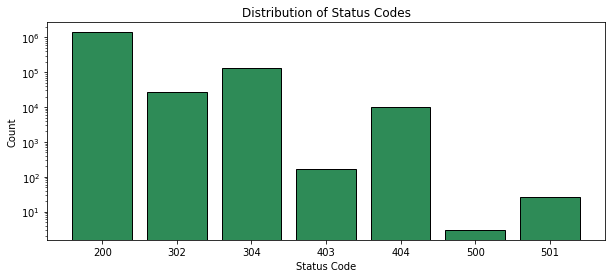

In [0]:
code_counts = []
for status in status_codes:
  code_counts.append(nasa.filter(lambda x : x[4] == status).count())
#print(code_counts)

plt.figure(figsize = [10, 4])
plt.bar(status_codes, code_counts, color = 'seagreen', edgecolor = 'k')
plt.title('Distribution of Status Codes')
plt.xlabel('Status Code')
plt.ylabel('Count')
plt.yscale('log')
plt.show()

## Part G: Request Volume by Day
Here, number of requests received by the server during each day in August 1995 is calculated and displayed.

Extract, aggregate the number of requests for each day of August 1995. Print the first five result.

In [0]:
counts_by_day = (
                  nasa.map(lambda x : (x[1][1:3], 1))
                      .reduceByKey(lambda x, y : (x + y))
                      .sortBy(lambda x : x[0])
                      .collect()
                      )
for counts in counts_by_day[:5]:
  print(counts)

('01', 33996)
('03', 41388)
('04', 59557)
('05', 31893)
('06', 32420)

Create the list of requests by date and display the result using bar chart.

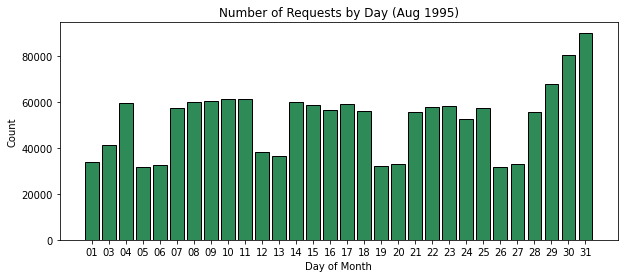

In [0]:
day_list = []
count_list = []

for count in counts_by_day:
  day_list.append(count[0])
  count_list.append(count[1]) 
  
plt.figure(figsize = [10, 4])
plt.bar(day_list, count_list, color = 'seagreen', edgecolor = 'k')
plt.title('Number of Requests by Day (Aug 1995)')
plt.xlabel('Day of Month')
plt.ylabel('Count')
plt.show()
